# Fit Batch Survival Model - Quadartic Fit

This notebook fits a qaudratic logit model to bacterial survival data as a function of RHL and HQNO concentrations. 

The model is fitted over different ranges of HQNO concentrations, to maximize goodness of fit in relevant concentration range of in microfluidic experiments

**Note: this model is not used and only provided for reference, the linear model was determined to provide better fit and is used in all subsequent notebooks**

In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
from matplotlib.colors import to_rgb

# — user parameters —
data_path = Path.cwd().parent / 'datafiles' / 'HQNO_RHL_Survival.csv'

# — transforms —
def logit(p, eps=1e-6):
    """ Logit transform with clipping to avoid inf values.
    Args:
        p (array-like): probabilities in [0, 1]
        eps (float): small value to clip probabilities
    Returns:
        array-like: logit-transformed values
    """
    p = np.clip(p, eps, 1 - eps)
    return np.log(p / (1 - p))

def inv_logit(z):
    """ Inverse logit transform.
    Args:
        z (array-like): logit values
    Returns:
        array-like: probabilities in [0, 1]
    """
    return 1 / (1 + np.exp(-z))

#    logit(Survival) = m1*RHL + m2*(RHL^2) + m3*HQNO + b
def model_quad(X, m1, m2, m3, b):
    rhl, rhl2, hqno = X
    return m1 * rhl + m2 * rhl2 + m3 * hqno + b


# — model: linear in RHL and HQNO —
def model_quad(X, m_rhl, m2_rhl, m_hqno, m2_hqno, b):
    """
    Linear logit model: logit(Survival) = m_rhl*RHL + m2_rhl*RHL + m_hqno*HQNO + m2_hqno*(HQNO^2) + b
    
    Args:
        X (array-like): 2D array with shape (4, N) where first row is RHL, second row is RHL^2, third row is HQNO, and fourth row is HQNO^2
        m_rhl (float): slope for RHL
        m2_rhl (float): quadratic term for RHL
        m_hqno (float): slope for HQNO
        m2_hqno (float): quadratic term for HQNO
        b (float): intercept
    Returns:
        array-like: logit-transformed survival values
    """
    rhl, rhl2, hqno, hqno2 = X
    return m_rhl * rhl + m2_rhl * rhl2 + m_hqno * hqno + m2_hqno * hqno2 + b

def fit_model(df):
    """ Fit linear logit model to data.
    Args:
        df (pd.DataFrame): DataFrame with columns "Rhamnolipids (µg/ml)", "HQNO (ng/ml)", "Survival
        Returns:
        params (tuple): Fitted parameters (m_rhl, m2_rhl, m_hqno, m2_hqno, b)
    """

    if "Rhamnolipids (µg/ml)" not in df.columns:
        raise ValueError("DataFrame must contain 'Rhamnolipids (µg/ml)' column")
    if "HQNO (ng/ml)" not in df.columns:
        raise ValueError("DataFrame must contain 'HQNO (ng/ml)' column")
    if "Survival" not in df.columns:
        raise ValueError("DataFrame must contain 'Survival' column")

    # — prepare data arrays —
    rhl_vals  = df["Rhamnolipids (µg/ml)"].values
    hqno_vals = df["HQNO (ng/ml)"].values
    surv_vals = df["Survival"].values
    y_logit   = logit(surv_vals)

    # — fit linear model —
    X = np.vstack((rhl_vals, rhl_vals**2, hqno_vals, hqno_vals**2))
    p0 = [0.0, 0.0, 0.0, 0.0, np.median(y_logit)]  # [m_rhl, m2_rhl, m_hqno, m2_hqno, b]
    params, _ = curve_fit(model_quad, X, y_logit, p0=p0)

    # Calculate R² for goodness of fit
    y_pred = model_quad(X, *params)
    ss_res = np.sum((y_logit - y_pred) ** 2)
    ss_tot = np.sum((y_logit - np.mean(y_logit)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)

    m_rhl, m2_rhl, m_hqno, m2_hqno, b = params
    print(f"Fitted params: m_rhl={m_rhl:.4f} ml/µg, m2_rhl={m2_rhl:.4f} (ml/µg)^2, m_hqno={m_hqno:.4f} ng/ml, m2_hqno={m2_hqno:.4f} (ng/ml)^2, b={b:.4f}, R²={r_squared:.4f}")

    params_out = {
        "model": "Quadratic-in-RHL-and-HQNO Logit",
        "parameters": {
            "m_rhl": float(m_rhl),
            "m2_rhl": float(m2_rhl),
            "m_hqno": float(m_hqno),
            "m2_hqno": float(m2_hqno),
            "b":  float(b),
        },
        "r_squared": float(r_squared),
        "units": {
            "Rhamnolipids": "µg/ml",
            "HQNO": "ng/ml"
        }
    }
    return params_out

def create_rhl_colors(n_levels):
    """Create purple gradient from light to dark based on #cc99ff.
    Lower RHL = lighter, higher RHL = darker"""
    base_color = np.array(to_rgb('#cc99ff'))
    colors = []
    for i in range(n_levels):
        # Start light (high factor) and go darker (low factor)
        # Reverse the progression: first level is lightest, last is darkest
        factor = 1.0 - 0.6 * (i / max(n_levels - 1, 1))
        color = base_color * factor
        colors.append(color)
    return colors

def plot_fit_results(df, df_below_lod, params, hqno_limit, fig_size=(8,6), font_size=12, ylim=(1e-7, 2)):
    """ Plot data and fitted model results.
    Args:
        df (pd.DataFrame): DataFrame with data
        df_below_lod (pd.DataFrame): DataFrame with data below limit of detection
        params (dict): Fitted parameters
        hqno_limit (float): Maximum HQNO value for filtering data   
        fig_size (tuple): Figure size in inches (width, height)
        font_size (int): Font size for plot text    
        ylim (tuple): y-axis limits for the plot
    """

    # get unique RHL levels and HQNO grid
    num_rhl_levels = len(df["Rhamnolipids (µg/ml)"].unique())
    rhl_levels = np.sort(df["Rhamnolipids (µg/ml)"].unique())
    hcol = "HQNO (ng/ml)"
    hqno_grid = np.linspace(df[hcol].min(), df[hcol].max(), 200)

    sns.set_theme(style="whitegrid")
    #colors = create_rhl_colors(num_rhl_levels)
    colors = sns.color_palette("Set2", n_colors=num_rhl_levels)
    symbols = ['o', 'd', '^', 'v']

    # plot data points
    plt.figure(figsize=fig_size)
    ax = sns.scatterplot(
        x=hcol, y="Survival",
        hue="Rhamnolipids (µg/ml)", hue_order=rhl_levels,
        palette=colors, data=df, s=40, alpha=0.7, 
        style="Rhamnolipids (µg/ml)", markers=symbols, style_order=rhl_levels
    )

    # Add jitter to x-values to reduce overlap
    np.random.seed(25)
    for collection in ax.collections:
        offsets = collection.get_offsets()
        if len(offsets) > 0:
            jitter = np.random.normal(0, 0.5, size=len(offsets))
            offsets[:, 0] += jitter
            collection.set_offsets(offsets)

    # plot below LOD points
    ax = sns.scatterplot(
        x=hcol, y="survival_lod",
        hue="Rhamnolipids (µg/ml)", hue_order=rhl_levels,
        palette=colors, data=df_below_lod, s=40, alpha=0.7, marker='X', legend=False
    )

    # plot fit lines
    for lvl, col in zip(rhl_levels, colors):
        z = model_quad(
            (np.full_like(hqno_grid, lvl), lvl**2, hqno_grid, hqno_grid**2),
            **params
        )
        plt.plot(hqno_grid, inv_logit(z), color=col, lw=2)

    # plot LOD area
    min_lod = df_below_lod['survival_lod'].min()
    max_lod = df_below_lod['survival_lod'].max()
    ax.axhspan(min_lod, max_lod, alpha=0.2, color='grey', zorder=0)

    # set plot titles and labels
    ax.set_title(f"Linear Logit Model in RHL and HQNO (max HQNO: {hqno_limit} ng/ml)", fontsize=font_size)
    ax.set_xlabel("HQNO (ng/ml)", fontsize=font_size)
    ax.set_ylabel("Survival", fontsize=font_size)

    ax.tick_params(axis='both', which='major', labelsize=font_size -1)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.legend(title="RHL (µg/ml)", bbox_to_anchor=(1.05,1), loc='upper left', fontsize=font_size, title_fontsize=font_size)
    plt.yscale("log")
    plt.ylim(ylim)
    plt.tight_layout()

    return ax

Fitting model with HQNO max limit: 40 ng/ml
Fitted params: m_rhl=-0.9203 ml/µg, m2_rhl=0.0161 (ml/µg)^2, m_hqno=0.0779 ng/ml, m2_hqno=0.0044 (ng/ml)^2, b=-3.1014, R²=0.7886


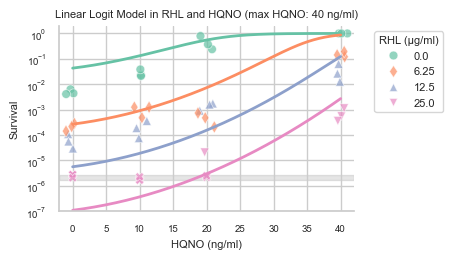

Grey area: area corresponding to limit of detection. Crosses: data points below LOD, plotted at their LOD value.
jitter added to x-values for better visibility.

------------------------------

Fitting model with HQNO max limit: 60 ng/ml
Fitted params: m_rhl=-0.9834 ml/µg, m2_rhl=0.0152 (ml/µg)^2, m_hqno=0.2419 ng/ml, m2_hqno=0.0004 (ng/ml)^2, b=-3.3112, R²=0.8258


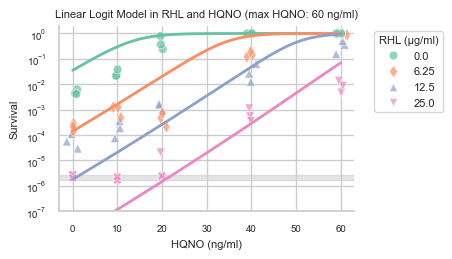

Grey area: area corresponding to limit of detection. Crosses: data points below LOD, plotted at their LOD value.
jitter added to x-values for better visibility.

------------------------------

Fitting model with HQNO max limit: 80 ng/ml
Fitted params: m_rhl=-0.9758 ml/µg, m2_rhl=0.0134 (ml/µg)^2, m_hqno=0.3347 ng/ml, m2_hqno=-0.0013 (ng/ml)^2, b=-3.7914, R²=0.8518


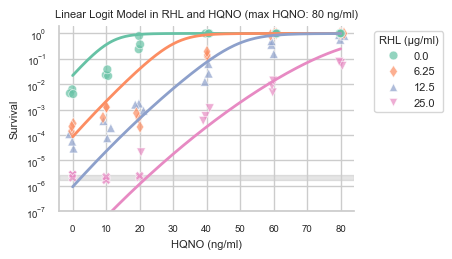

Grey area: area corresponding to limit of detection. Crosses: data points below LOD, plotted at their LOD value.
jitter added to x-values for better visibility.

------------------------------

Final combined results saved to ./data/survival_model_parameters.json
Keys in combined results: ['hqno_max_40', 'hqno_max_60', 'hqno_max_80']


In [ ]:
# set parameters for fitting
max_hqno_fit = [40, 60, 80]
time_point_h = 2
min_cfu_lod = 200  # CFU limit of detection

# ——— figure style ———
final_width_in = 12 / 2.54
final_height_in = 7 / 2.54
font_size = 8  # points
plt.rcParams.update({
    'font.size': font_size,
    'pdf.fonttype': 42,
    'ps.fonttype': 42
})

# Initialize combined results dictionary and overwrite JSON file at start
combined_results = {}
json_path = "./data/survival_model_parameters_quadratic.json"

# load data
df_raw = pd.read_csv(data_path)

# add HQNO in ng/ml for consistency
df_raw['HQNO (ng/ml)'] = df_raw['HQNO (µg/ml)'] * 1000

# add fractional survival
df_t0 = df_raw[df_raw['Timepoint (h)'] == 0][['Rhamnolipids (µg/ml)', 'HQNO (ng/ml)', 'Replicate', 'CFU']].copy()
df_t0 = df_t0.rename(columns={'CFU': 'CFU_t0'})
df_all = df_raw.merge(df_t0, on=['Rhamnolipids (µg/ml)', 'HQNO (ng/ml)', 'Replicate'], how='left')
df_all['Survival'] = df_all['CFU'] / df_all['CFU_t0']

# Clip survival values to maximum of 1 (some early timepoints show survival > 100%)
df_all["Survival"] = df_all["Survival"].clip(upper=1.0)

# add limit of detection
df_all['survival_lod'] = min_cfu_lod / df_all['CFU_t0']
df_all['below_lod'] =   df_all['Survival'] < df_all['survival_lod']
df_all = df_all.drop(columns=['CFU_t0'])

# filter to 2h timepoint
df_2h = df_all[(df_all["Timepoint (h)"] == time_point_h)].copy()

for hqno_limit in max_hqno_fit:
    print(f"Fitting model with HQNO max limit: {hqno_limit} ng/ml") 

    # filter up to and including hqno_limit
    df = df_2h[df_2h["HQNO (ng/ml)"] <= hqno_limit].copy()

    # filter out below LOD
    df_below_lod = df[df['below_lod']] # store for reference
    df = df[~df['below_lod']]

    # — fit model —
    params_out = fit_model(df)
    params_out['hqno_max_ng_ml'] = hqno_limit
    params_out['time_point_h'] = time_point_h

    # Add to combined results dictionary indexed by hqno_limit
    combined_results[f"hqno_max_{hqno_limit}"] = params_out
        
    # — visualize fit —
    ax = plot_fit_results(
        df, df_below_lod,
        params=params_out['parameters'],
        hqno_limit=hqno_limit,
        fig_size=(final_width_in, final_height_in),
        font_size=font_size,
        ylim=(1e-7, 2)
    )
    #plt.savefig(f"./figures/logit_fit_survival_data_hqno_max_{hqno_limit}.pdf", dpi=300, transparent=True)
    plt.show()

    print("Grey area: area corresponding to limit of detection. Crosses: data points below LOD, plotted at their LOD value.")
    print("jitter added to x-values for better visibility.")
    print("\n------------------------------\n")

# — save combined parameters to JSON after each iteration —
# with open(json_path, "w", encoding="utf-8") as f:
#     json.dump(combined_results, f, indent=2)

%print(f"Final combined results saved to {json_path}")
print("Keys in combined results:", list(combined_results.keys()))
